In [1]:
# --- Libraries

import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import math
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics
from tensorflow.keras.saving import register_keras_serializable
from sklearn.model_selection import train_test_split

In [ ]:
# --- 1 Configuration

# 1.1 Seeds
np.random.seed(2077)
tf.random.set_seed(2077)
random.seed(2077)

# 1.2 Set the global policy for mixed precision.
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.set_global_policy(policy)

# 1.3 Patch dimensions for High-Resolution (HR) and Low-Resolution (LR) images
PATCH_H = 256
PATCH_W = 256
PATCH_LR_H = PATCH_H // 2
PATCH_LR_W = PATCH_W // 2
UPSCALE_FACTOR = 2
CH = 3

# 1.4 Training (lighter)
BATCH_SIZE  = 32    # was 32
EPOCHS      = 20    # was 100
SAMPLE_SIZE = 500   # set to None if you want full dataset

# 1.5 Which models to train (keep logic, just make it controllable)
TRAIN_MAE  = True

In [5]:
# --- 2 Collection of image paths

base_folder = './Flickr2K'
all_paths = []

pattern = os.path.join(base_folder, f"*.png")
for f in glob.glob(pattern):
    try:
        if os.path.getsize(f) > 0:
            all_paths.append(f)
    except OSError:
        continue

train_paths, test_paths = train_test_split(all_paths, test_size=0.1, random_state=2077)
train_paths, val_paths  = train_test_split(train_paths, test_size=0.2, random_state=2077)

# apply sampling (new)
if SAMPLE_SIZE is not None:
    train_paths = train_paths[:SAMPLE_SIZE]
    val_paths   = val_paths[:max(1, SAMPLE_SIZE // 5)]
    test_paths  = test_paths[:max(1, SAMPLE_SIZE // 5)]

print(f"In the dataset there are 2650 images, I was able to identify {len(all_paths)} images.")
print(f"Of these {len(train_paths)} image, {len(val_paths)} will be used for validation and {len(test_paths)} will be used for test.")

In the dataset there are 2650 images, I was able to identify 2650 images.
Of these 500 image, 100 will be used for validation and 100 will be used for test.


In [6]:
# --- 3 Minimum height and width between all images.

min_height = np.inf
min_width  = np.inf

for path in all_paths:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Can't read this image: {path}")
        continue
    h, w = img.shape[:2]
    if h < min_height:
        min_height = h
    if w < min_width:
        min_width = w

if min_height == np.inf or min_width == np.inf:
    print("No valid image")
else:
    print(f"Minimum hight between all images : {min_height}")
    print(f"Minimum width between all images : {min_width}")

Minimum hight between all images : 816
Minimum width between all images : 1020


In [7]:
# --- 4 Degradation Function

def degradation_pipeline_np(image_input):
    if isinstance(image_input, tf.Tensor):
        hr_image_np = image_input.numpy()
    else:
        hr_image_np = image_input

    img = (hr_image_np * 255.0).astype(np.float32)
    h, w, _ = img.shape
    lr_h, lr_w = h // UPSCALE_FACTOR, w // UPSCALE_FACTOR

    small = cv2.resize(img, (lr_w, lr_h), interpolation=cv2.INTER_AREA)

    kernel_size = random.choice([(3, 3), (5, 5), (7, 7)])
    sigma_x = np.random.uniform(0.5, 2.5)
    small = cv2.GaussianBlur(small, kernel_size, sigma_x)

    noise_std = np.random.uniform(5, 35)
    noise = np.random.normal(0, noise_std, small.shape).astype(np.float32)
    small = small + noise

    if np.random.rand() < 0.5:
        quality = np.random.randint(30, 95)
        _, enc = cv2.imencode(".jpg", small, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
        small = cv2.imdecode(enc, 1).astype(np.float32)

    small_clipped = np.clip(small, 0.0, 255.0)
    lr_final = small_clipped / 255.0

    return lr_final.astype(np.float32)

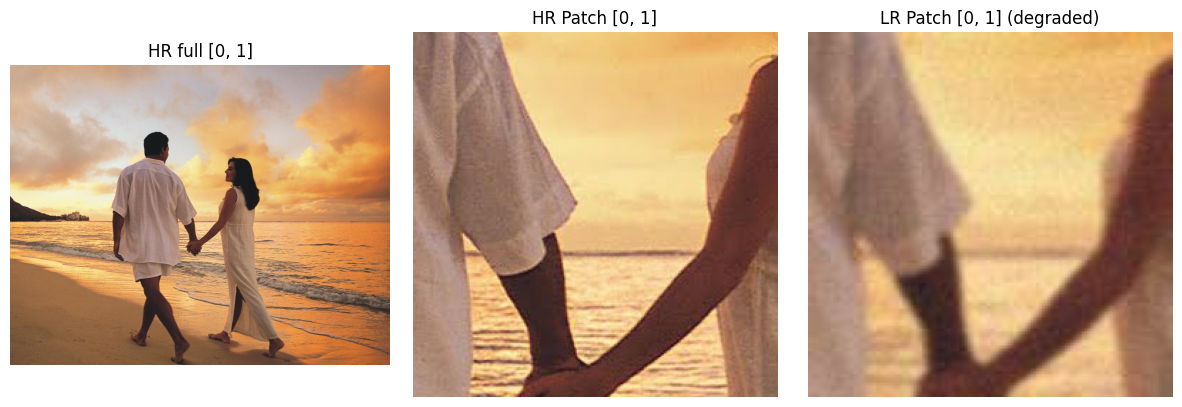

In [8]:
# --- 5 Visualization of the degradation function

random_path = random.choice(train_paths)
hr_full = tf.image.convert_image_dtype(tf.io.decode_png(tf.io.read_file(random_path), channels=CH), tf.float32)
hr_patch = tf.image.resize_with_crop_or_pad(hr_full, PATCH_H, PATCH_W)

lr_patch_degraded = degradation_pipeline_np(hr_patch.numpy())

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("HR full [0, 1]")
plt.imshow(hr_full)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title("HR Patch [0, 1]")
plt.imshow(hr_patch)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.title("LR Patch [0, 1] (degraded)")
plt.imshow(lr_patch_degraded)
plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
# --- 6 Data loading and preprocessing function

def load_and_preprocess(path, training):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=CH)
    img = tf.image.convert_image_dtype(img, tf.float32)

    if training:
        hr_patch = tf.image.random_crop(img, [PATCH_H, PATCH_W, CH])
        hr_patch = tf.image.random_flip_left_right(hr_patch)
        hr_patch = tf.image.random_flip_up_down(hr_patch)
        k = tf.random.uniform([], 0, 4, tf.int32)
        hr_patch = tf.image.rot90(hr_patch, k)
        hr_patch = tf.image.random_brightness(hr_patch, max_delta=0.1)
        hr_patch = tf.image.random_contrast(hr_patch, lower=0.8, upper=1.2)
        hr_patch = tf.image.random_saturation(hr_patch, lower=0.85, upper=1.15)
        hr_patch = tf.image.random_hue(hr_patch, max_delta=0.08)
        hr_patch = tf.clip_by_value(hr_patch, 0.0, 1.0)
    else:
        hr_patch = tf.image.resize_with_crop_or_pad(img, PATCH_H, PATCH_W)

    lr_patch_0_1 = tf.py_function(
        func=degradation_pipeline_np,
        inp=[hr_patch],
        Tout=tf.float32
    )

    lr_patch = (lr_patch_0_1 * 2.0) - 1.0
    hr_patch_norm = (hr_patch * 2.0) - 1.0

    lr_patch.set_shape([PATCH_LR_H, PATCH_LR_W, CH])
    hr_patch_norm.set_shape([PATCH_H, PATCH_W, CH])

    return lr_patch, hr_patch_norm

In [10]:
# --- 7 Dataset creation

def make_dataset(paths, training):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    if training:
        ds = ds.shuffle(buffer_size=min(len(paths), 1000))
    ds = ds.map(lambda p: load_and_preprocess(p, training),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_paths, training=True)
val_ds   = make_dataset(val_paths,   training=False)
test_ds  = make_dataset(test_paths,  training=False)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")
print(train_ds)
print(val_ds)
print(test_ds)

Train: 500, Val: 100, Test: 100
<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None))>


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import register_keras_serializable

# --- Define Missing Constants ---
# Assuming 3-channel (RGB) input
CH = 3
# Assuming a 2x upscale factor based on the UpSampling2D(size=(2, 2))
UPSCALE_FACTOR = 2
NUM_BOTTLENECK_BLOCKS = 6
# --- 8 U-Net

def se_block(input_tensor, ratio=8):
    channels = int(input_tensor.shape[-1])
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, channels))(se)
    se = layers.Conv2D(max(1, channels // ratio), 1, activation="relu", use_bias=True)(se)
    se = layers.Conv2D(channels, 1, activation="sigmoid", use_bias=True)(se)
    return layers.Multiply()([input_tensor, se])

@register_keras_serializable()
class PixelShuffle(layers.Layer):
    # FIX: Changed _init_ to __init__ (double underscores)
    def __init__(self, block_size=2, **kwargs):
        # accept the arg, pass the rest to keras.Layer
        # FIX: Changed super()._init_ to super().__init__
        super().__init__(**kwargs)
        self.block_size = block_size

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.block_size)

    def get_config(self):
        config = super().get_config()
        config.update({"block_size": self.block_size})
        return config

def enc_block_super(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", use_bias=True)(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.Conv2D(filters, 3, strides=2, padding="same", use_bias=True)(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = se_block(x)
    return x

def bot_block(x, filters):
    b = layers.Conv2D(filters, 3, padding="same", use_bias=True)(x)
    b = layers.LayerNormalization()(b)
    b = layers.LeakyReLU(0.1)(b)
    b = layers.Dropout(0.2)(b)
    residual_bottleneck = layers.Conv2D(filters, 3, padding="same", use_bias=True)(b)
    residual_bottleneck = layers.LayerNormalization()(residual_bottleneck)
    b = layers.Add()([x, residual_bottleneck])
    b = layers.LeakyReLU(0.1)(b)
    b = se_block(b)
    return b

def dec_block_super(x, skip, filters):
    # upsample
    x = layers.Conv2D(filters * (UPSCALE_FACTOR**2), 3, padding="same", use_bias=True)(x)
    # 👇 POSitional call, no keyword
    x = PixelShuffle(UPSCALE_FACTOR)(x) # This will now call the correct __init__
    x = layers.LeakyReLU(0.1)(x)
    x = layers.Concatenate()([x, skip])
    x = layers.Conv2D(filters, 3, padding="same", use_bias=True)(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(filters, 3, padding="same", use_bias=True)(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    return x

def build_upgraded_unet_sr():
    inputs = layers.Input((None, None, CH))
    upsampled_lr_base = layers.UpSampling2D(size=(UPSCALE_FACTOR, UPSCALE_FACTOR), interpolation="bilinear")(inputs)

    s0 = layers.Conv2D(64, 3, padding="same", use_bias=True)(inputs)
    s0 = layers.LeakyReLU(0.1)(s0)

    e1 = enc_block_super(s0, 64)
    e2 = enc_block_super(e1, 128)
    e3 = enc_block_super(e2, 256)

    b = e3
    for _ in range(NUM_BOTTLENECK_BLOCKS):
        b = bot_block(b, 256)

    d3 = dec_block_super(b, e2, 128)
    d2 = dec_block_super(d3, e1, 64)
    d1 = dec_block_super(d2, s0, 64)

    x = layers.Conv2D(CH * (UPSCALE_FACTOR**2), 3, padding="same")(d1)
    # 👇 also positional here
    residual_output = PixelShuffle(UPSCALE_FACTOR)(x)
    residual_output = layers.Activation("tanh", dtype=tf.float32)(residual_output)
    outputs = layers.Add(dtype=tf.float32)([upsampled_lr_base, residual_output])

    return keras.Model(inputs, outputs, name="UNet_SR")

# build models
final_model_mae = build_upgraded_unet_sr()
final_model_a005 = build_upgraded_unet_sr()
final_model_a02 = build_upgraded_unet_sr()
final_model_a02.summary()

print("\nModel built successfully!")




Model: "UNet_SR"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, None, None, 64)       1792      ['input_3[0][0]']             
                                                                                                  
 leaky_re_lu_56 (LeakyReLU)  (None, None, None, 64)       0         ['conv2d_94[0][0]']           
                                                                                                  
 conv2d_95 (Conv2D)          (None, None, None, 64)       36928     ['leaky_re_lu_56[0][0]']      
                                                                                          

In [12]:
# --- 9 Loss Functions

pixel_loss = keras.losses.MeanAbsoluteError()

def mae_only_loss(y_true, y_pred):
    return pixel_loss(y_true, y_pred)

# 9.2 Advance: MAE + Perceptual (VGG19) loss
vgg = VGG19(include_top=False, weights="imagenet")
vgg.trainable = False

feat_ext_block5_conv4 = keras.Model(
    inputs=vgg.input,
    outputs=vgg.get_layer("block5_conv4").output
)

def perceptual_block5(y_true, y_pred):
    y_true_0_255 = ((tf.cast(y_true, tf.float32) + 1.0) / 2.0) * 255.0
    y_pred_0_255 = ((tf.cast(y_pred, tf.float32) + 1.0) / 2.0) * 255.0

    if tf.rank(y_true_0_255) == 3:
        y_true_batch = tf.expand_dims(y_true_0_255, axis=0)
    else:
        y_true_batch = y_true_0_255
    if tf.rank(y_pred_0_255) == 3:
        y_pred_batch = tf.expand_dims(y_pred_0_255, axis=0)
    else:
        y_pred_batch = y_pred_0_255

    yt = preprocess_input(y_true_batch)
    yp = preprocess_input(y_pred_batch)

    ft = feat_ext_block5_conv4(yt)
    fp = feat_ext_block5_conv4(yp)

    return pixel_loss(ft, fp)

def sr_loss_block5(y_true, y_pred):
    pixel_l = pixel_loss(y_true, y_pred)
    perceptual_l = perceptual_block5(y_true, y_pred)
    return pixel_l + 0.005 * perceptual_l

def sr_loss_block5_alpha(y_true, y_pred):
    pixel_l = pixel_loss(y_true, y_pred)
    perceptual_l = perceptual_block5(y_true, y_pred)
    return pixel_l + 0.02 * perceptual_l

In [13]:
# --- 10 Callbacks

def create_standard_callbacks(checkpoint_path, patience_es=12, patience_lr=3):
    return [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            save_best_only=True,
            monitor="val_loss",
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            patience=patience_es,
            restore_best_weights=True,
            monitor="val_loss",
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.2,
            patience=patience_lr,
            min_lr=1e-6,
            monitor="val_loss",
            verbose=1
        )
    ]

CHECKPOINT_MAE  = "checkpoint_mae.keras"
CHECKPOINT_A005 = "checkpoint_a005.keras"
CHECKPOINT_A02  = "checkpoint_a02.keras"

callbacks_mae  = create_standard_callbacks(CHECKPOINT_MAE)
callbacks_a005 = create_standard_callbacks(CHECKPOINT_A005)
callbacks_a02  = create_standard_callbacks(CHECKPOINT_A02)

In [14]:
# --- 11 Additional Metrics

def denorm_for_metric(tensor):
    return (tensor + 1.0) / 2.0

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(denorm_for_metric(y_true), denorm_for_metric(y_pred), max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(denorm_for_metric(y_true), denorm_for_metric(y_pred), max_val=1.0)

In [ ]:
# ---- 12 ---- Define optimizer for mixed precision
optimizer_mae = tf.keras.mixed_precision.LossScaleOptimizer(
    keras.optimizers.Adam(5e-4), dynamic=True)

optimizer_a005 = tf.keras.mixed_precision.LossScaleOptimizer(
    keras.optimizers.Adam(5e-4), dynamic=True)

optimizer_a02 = tf.keras.mixed_precision.LossScaleOptimizer(
    keras.optimizers.Adam(5e-4), dynamic=True)

# --- 13.1 Compile U-Net with MAE
final_model_mae.compile(
    optimizer=optimizer_mae,
    loss=mae_only_loss,
    metrics=[
        psnr_metric,
        ssim_metric,
        keras.metrics.MeanAbsoluteError(name="mae")
    ]
)

if TRAIN_MAE:
    history_mae = final_model_mae.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks_mae
    )

Epoch 1/20


15/15 [==============================] - ETA: 0s - loss: 0.2936 - psnr_metric: 15.3113 - ssim_metric: 0.0915 - mae: 0.2936  
Epoch 1: val_loss improved from inf to 0.14820, saving model to checkpoint_mae.keras
15/15 [==============================] - 3192s 211s/step - loss: 0.2936 - psnr_metric: 15.3113 - ssim_metric: 0.0915 - mae: 0.2936 - val_loss: 0.1482 - val_psnr_metric: 20.2995 - val_ssim_metric: 0.3432 - val_mae: 0.1482 - lr: 5.0000e-04
Epoch 2/20
15/15 [==============================] - ETA: 0s - loss: 0.1716 - psnr_metric: 19.3503 - ssim_metric: 0.1977 - mae: 0.1716  
Epoch 2: val_loss improved from 0.14820 to 0.13889, saving model to checkpoint_mae.keras
15/15 [==============================] - 3165s 211s/step - loss: 0.1716 - psnr_metric: 19.3503 - ssim_metric: 0.1977 - mae: 0.1716 - val_loss: 0.1389 - val_psnr_metric: 20.8241 - val_ssim_metric: 0.3994 - val_mae: 0.1389 - lr: 5.0000e-04
Epoch 3/20
15/15 [==============================] - ETA: 0s - loss: 0.1450 -

NameError: name 'plot_three_metrics' is not defined

In [36]:
final_model_a005.save("model_mae.keras")

In [18]:
import matplotlib.pyplot as plt

def plot_three_metrics(history, title_prefix="Model"):
    """Plot training and validation loss and MAE."""
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title_prefix} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot MAE
    if 'mae' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Train MAE')
        plt.plot(history.history['val_mae'], label='Val MAE')
        plt.title(f"{title_prefix} - MAE")
        plt.xlabel("Epochs")
        plt.ylabel("MAE")
        plt.legend()

    plt.tight_layout()
    plt.show()


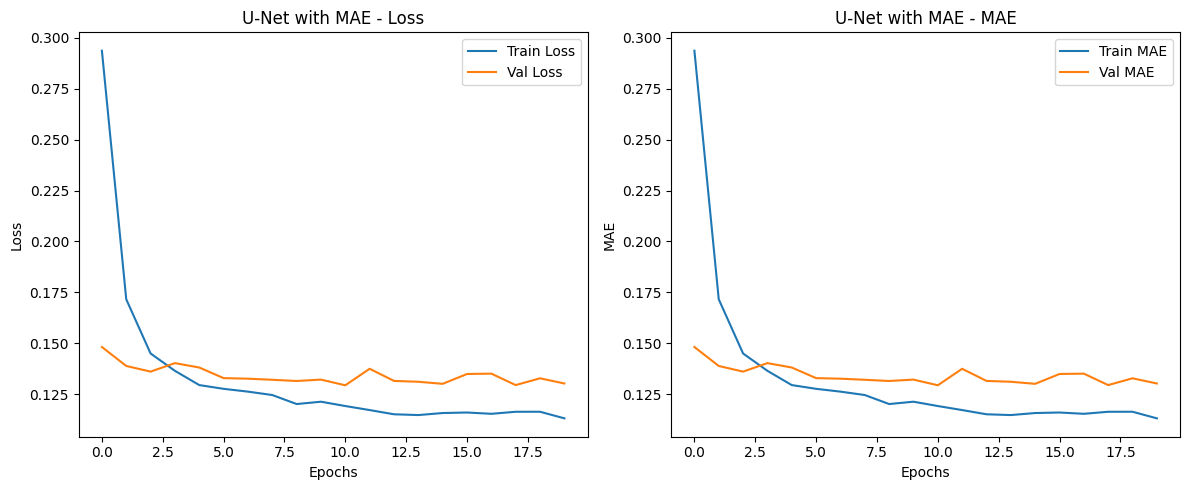

In [19]:
plot_three_metrics(history_mae, title_prefix="U-Net with MAE")


In [21]:
TRAIN_A005 = True
# --- 1. Setup optimizer for mixed precision
optimizer_a005 = tf.keras.mixed_precision.LossScaleOptimizer(
    keras.optimizers.Adam(5e-4), dynamic=True
)

# --- 2. Ensure loss function handles mixed precision
def sr_loss_block5(y_true, y_pred):
    """Pixel + perceptual loss (alpha=0.005) with correct dtype casting for mixed precision."""
    pixel_l = mae_only_loss(y_true, y_pred)           # pixel/MAE loss
    perceptual_l = perceptual_block5(y_true, y_pred) # perceptual loss

    # Cast to float32 to avoid float16 + float32 type errors
    pixel_l = tf.cast(pixel_l, tf.float32)
    perceptual_l = tf.cast(perceptual_l, tf.float32)

    return pixel_l + 0.005 * perceptual_l

# --- 3. Compile the model
final_model_a005.compile(
    optimizer=optimizer_a005,
    loss=sr_loss_block5,
    metrics=[
        perceptual_block5,
        keras.metrics.MeanAbsoluteError(name="mae"),
        psnr_metric,
        ssim_metric
    ]
)

# --- 4. Checkpoint callback to save best model
checkpoint_a005 = keras.callbacks.ModelCheckpoint(
    "checkpoint_a005.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Optional: learning rate scheduler (if you already have it)
callbacks_a005 = [checkpoint_a005]  # add other callbacks if needed

# --- 5. Train the model (if flag is True)
if TRAIN_A005:
    history_a005 = final_model_a005.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks_a005
    )

    # --- 6. Optional: plot metrics
    if 'plot_three_metrics' in globals():
        plot_three_metrics(history_a005, title_prefix="U-Net Perceptual alpha=0.005")

    # --- 7. Optional: save final model (not required if checkpoint is enough)
    final_model_a005.save("model_a005.keras")


Epoch 1/20
15/15 [==============================] - ETA: 0s - loss: 0.2925 - perceptual_block5: 1.0681 - mae: 0.2871 - psnr_metric: 15.4602 - ssim_metric: 0.0982  
Epoch 1: val_loss improved from inf to 0.14822, saving model to checkpoint_a005.keras
15/15 [==============================] - 9004s 600s/step - loss: 0.2925 - perceptual_block5: 1.0681 - mae: 0.2871 - psnr_metric: 15.4602 - ssim_metric: 0.0982 - val_loss: 0.1482 - val_perceptual_block5: 1.0599 - val_mae: 0.1429 - val_psnr_metric: 20.5434 - val_ssim_metric: 0.3605
Epoch 2/20
15/15 [==============================] - ETA: 0s - loss: 0.1725 - perceptual_block5: 0.9617 - mae: 0.1677 - psnr_metric: 19.5489 - ssim_metric: 0.1964   
Epoch 2: val_loss improved from 0.14822 to 0.14237, saving model to checkpoint_a005.keras
15/15 [==============================] - 14412s 987s/step - loss: 0.1725 - perceptual_block5: 0.9617 - mae: 0.1677 - psnr_metric: 19.5489 - ssim_metric: 0.1964 - val_loss: 0.1424 - val_perceptual_block5: 1.0413 - v

KeyboardInterrupt: 

In [33]:
final_model_a005.save("model_a005.keras")

In [37]:
# --- 16 Load models + Evaluation

custom_objects = {
    "mae_only_loss": mae_only_loss,
    "sr_loss_block5": sr_loss_block5,
    "sr_loss_block5_alpha": sr_loss_block5_alpha,
    "perceptual_block5": perceptual_block5,
    "pixel_loss": pixel_loss,
    "psnr_metric": psnr_metric,
    "ssim_metric": ssim_metric,
    "PixelShuffle": PixelShuffle
}

#model_mae  = load_model("model_mae.keras",  custom_objects=custom_objects, safe_mode=False) if TRAIN_MAE else final_model_mae
model_a005 = load_model("model_a005.keras", custom_objects=custom_objects, safe_mode=False) if TRAIN_A005 else final_model_a005
print("Models loaded successfully.")

#res_mae  = model_mae.evaluate(test_ds, return_dict=True)
res_a005 = model_a005.evaluate(test_ds, return_dict=True)
print("\nModel evaluated.")


Models loaded successfully.
3/3 [==============================] - 49s 15s/step - loss: 0.1324 - perceptual_block5: 1.0365 - mae: 0.1272 - psnr_metric: 21.8555 - ssim_metric: 0.3867

Model evaluated.


In [47]:
# --- 17 Evaluation
# Evaluate MAE model (if trained)
res_mae = final_model_mae.evaluate(test_ds, return_dict=True)

# Evaluate perceptual alpha=0.005 model (if trained)
res_a005 = final_model_a005.evaluate(test_ds, return_dict=True)

print("\n--- FINAL EVALUATION RESULTS ---\n")
print("Evaluation U-Net + MAE")
print(f"Test Loss (MAE): {res_mae['loss']:.4f}")
print(f"Test PSNR: {res_mae.get('psnr_metric', float('nan')):.4f}")
print(f"Test SSIM: {res_mae.get('ssim_metric', float('nan')):.4f}")
print(f"Test MAE: {res_mae.get('mae', float('nan')):.4f}")
print("-" * 30)

print("Evaluation U-Net + Perceptual Loss (alpha=0.005)")
print(f"Test Combined Loss: {res_a005['loss']:.4f}")
print(f"Test Perceptual Loss: {res_a005.get('perceptual_block5', float('nan')):.4f}")
print(f"Test MAE: {res_a005.get('mae', float('nan')):.4f}")
print(f"Test PSNR: {res_a005.get('psnr_metric', float('nan')):.4f}")
print(f"Test SSIM: {res_a005.get('ssim_metric', float('nan')):.4f}")
print("-" * 30)



3/3 [==============================] - 47s 15s/step - loss: 0.1256 - perceptual_block5: 1.0246 - mae: 0.1205 - psnr_metric: 22.2804 - ssim_metric: 0.4274

--- FINAL EVALUATION RESULTS ---

Evaluation U-Net + MAE
Test Loss (MAE): 0.1205
Test PSNR: 22.2696
Test SSIM: 0.4302
Test MAE: 0.1205
------------------------------
Evaluation U-Net + Perceptual Loss (alpha=0.005)
Test Combined Loss: 0.1256
Test Perceptual Loss: 1.0246
Test MAE: 0.1205
Test PSNR: 22.2804
Test SSIM: 0.4274
------------------------------


In [55]:
from tensorflow.keras.models import load_model

# Load both trained models (no need to re-train)
model_mae = load_model("model_mae.keras", compile=False)
model_a005 = load_model("model_a005.keras", compile=False)


In [56]:
import random
import tensorflow as tf

# --- 18 Preparation for the Patch Visualization 

# Randomly pick one HR image from the test set
sample_path_hr = random.choice(test_paths)

# Decode image as float32 in [0,1] range
hr_full_image = tf.image.convert_image_dtype(
    tf.io.decode_png(tf.io.read_file(sample_path_hr), channels=CH),
    tf.float32
)

# Crop or pad to required patch size
hr_patch_gt = tf.image.resize_with_crop_or_pad(hr_full_image, PATCH_H, PATCH_W)

# Degrade image (simulate low-resolution)
lr_patch_degraded_0_1 = degradation_pipeline_np(hr_patch_gt.numpy())

# Normalize inputs to [-1, 1]
lr_patch_input = (lr_patch_degraded_0_1 * 2.0) - 1.0
hr_patch_for_model = (hr_patch_gt.numpy() * 2.0) - 1.0

# Get predictions from both models
sr_patch_predicted_mae  = model_mae.predict(lr_patch_input[None, ...])[0]
sr_patch_predicted_a005 = model_a005.predict(lr_patch_input[None, ...])[0]


1/1 [==============================] - 1s 1s/step


In [57]:
# --- 18 Preparation for the Patch Visualization

sample_path_hr = random.choice(test_paths)
hr_full_image = tf.image.convert_image_dtype(
    tf.io.decode_png(tf.io.read_file(sample_path_hr), channels=CH),
    tf.float32
)

hr_patch_gt = tf.image.resize_with_crop_or_pad(hr_full_image, PATCH_H, PATCH_W)
lr_patch_degraded_0_1 = degradation_pipeline_np(hr_patch_gt.numpy())

lr_patch_input = (lr_patch_degraded_0_1 * 2.0) - 1.0
hr_patch_for_model = (hr_patch_gt.numpy() * 2.0) - 1.0

sr_patch_predicted_mae  = model_mae.predict(lr_patch_input[None, ...])[0]
sr_patch_predicted_a005 = model_a005.predict(lr_patch_input[None, ...])[0]


1/1 [==============================] - 0s 116ms/step


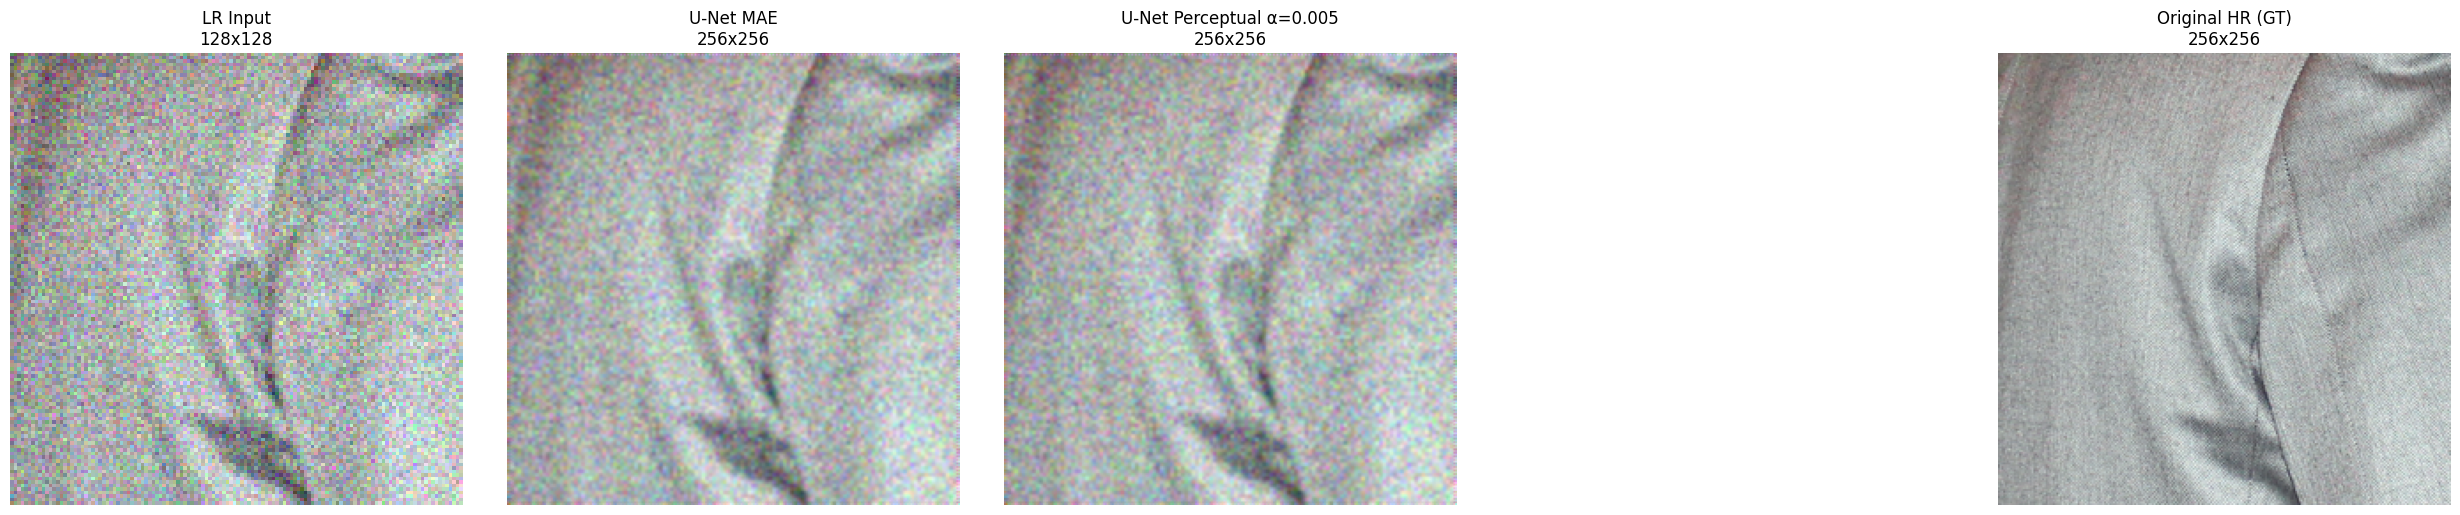

In [59]:
# --- 19 Visualization of the Model Prediction

def denorm(img):
    img_f32 = tf.cast(img, tf.float32)
    return tf.clip_by_value((img_f32 + 1.0) / 2.0, 0, 1)

plt.figure(figsize=(25, 5))

plt.subplot(1, 5, 1)
plt.title(f"LR Input\n{PATCH_LR_H}x{PATCH_LR_W}")
plt.imshow(denorm(lr_patch_input))
plt.axis("off")

plt.subplot(1, 5, 2)
plt.title(f"U-Net MAE\n{PATCH_H}x{PATCH_W}")
plt.imshow(denorm(sr_patch_predicted_mae))
plt.axis("off")

plt.subplot(1, 5, 3)
plt.title(f"U-Net Perceptual α=0.005\n{PATCH_H}x{PATCH_W}")
plt.imshow(denorm(sr_patch_predicted_a005))
plt.axis("off")

plt.subplot(1, 5, 5)
plt.title(f"Original HR (GT)\n{PATCH_H}x{PATCH_W}")
plt.imshow(hr_patch_gt)
plt.axis("off")

plt.tight_layout()
plt.show()


In [60]:
# --- 20 Full Image Inference Functions

def predict_full_image_tiled(model, lr_image_norm, patch_size=128, overlap=32, batch_size=8):
    lr_h, lr_w, C = lr_image_norm.shape
    stride = patch_size - overlap

    n_patches_h = math.ceil(max(0, lr_h - patch_size) / stride) + 1
    n_patches_w = math.ceil(max(0, lr_w - patch_size) / stride) + 1
    pad_h = (n_patches_h - 1) * stride + patch_size - lr_h
    pad_w = (n_patches_w - 1) * stride + patch_size - lr_w

    lr_padded = np.pad(lr_image_norm, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

    patches = []
    for iy in range(n_patches_h):
        for ix in range(n_patches_w):
            y = iy * stride
            x = ix * stride
            patch = lr_padded[y:y+patch_size, x:x+patch_size, :]
            patches.append(patch)
    patches = np.stack(patches, axis=0).astype(np.float32)

    preds_norm = model.predict(patches, batch_size=batch_size, verbose=0)

    patch_hr_size = patch_size * UPSCALE_FACTOR
    stride_hr = stride * UPSCALE_FACTOR
    hr_h, hr_w = lr_padded.shape[0] * UPSCALE_FACTOR, lr_padded.shape[1] * UPSCALE_FACTOR

    final_hr = np.zeros((hr_h, hr_w, C), dtype=np.float32)
    weight_map = np.zeros_like(final_hr)

    hann_1d = np.hanning(patch_hr_size)
    window_2d = np.outer(hann_1d, hann_1d)[..., None]

    idx = 0
    for iy in range(n_patches_h):
        for ix in range(n_patches_w):
            y, x = iy * stride_hr, ix * stride_hr
            final_hr[y:y+patch_hr_size, x:x+patch_hr_size, :] += preds_norm[idx] * window_2d
            weight_map[y:y+patch_hr_size, x:x+patch_hr_size, :] += window_2d
            idx += 1

    final_hr = final_hr / (weight_map + 1e-8)

    orig_hr_h, orig_hr_w = lr_h * UPSCALE_FACTOR, lr_w * UPSCALE_FACTOR
    final_hr_cropped = final_hr[:orig_hr_h, :orig_hr_w, :]

    return final_hr_cropped



--- Generating SR image for model: U-Net MAE ---

--- Generating SR image for model: U-Net Perceptual α=0.005 ---


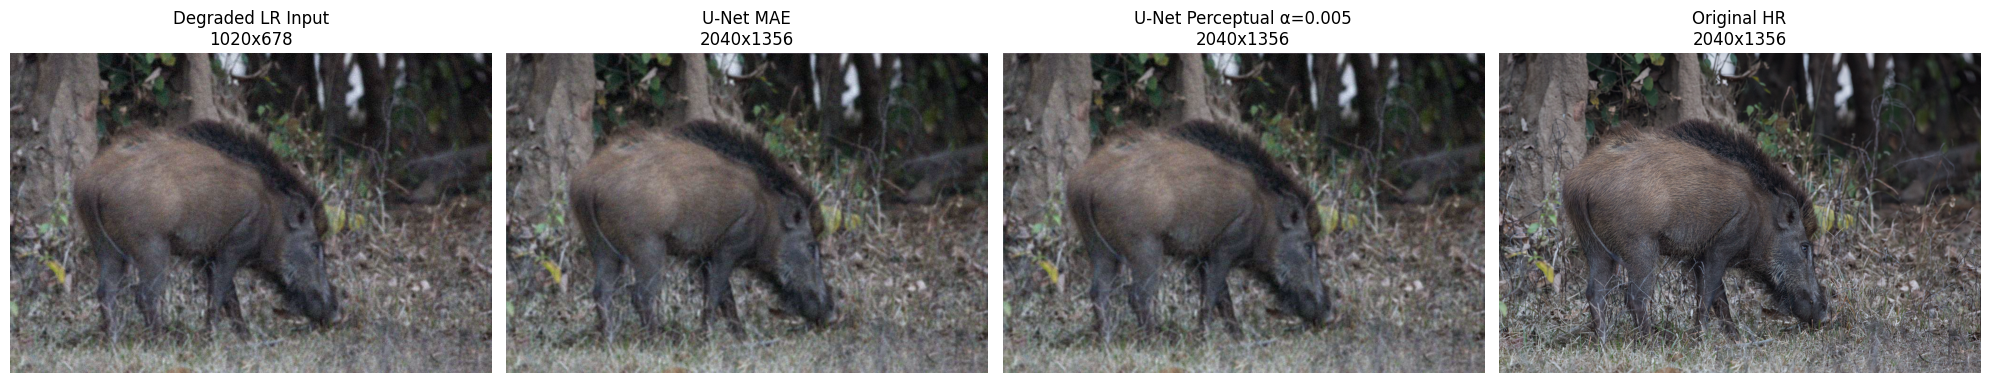

In [62]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- 21 Final Full Image Visualization (for MAE and A005) ---

models_to_evaluate = {
    "U-Net MAE": model_mae,
    "U-Net Perceptual α=0.005": model_a005
}

sr_images = {}

# Randomly select a high-resolution image from your test set
sample_path_full = random.choice(test_paths)

# Read and normalize HR image
hr_full_original = tf.image.convert_image_dtype(
    tf.io.decode_png(tf.io.read_file(sample_path_full), channels=CH),
    tf.float32
).numpy()

# Degrade to create a low-resolution version
lr_full_input_degraded = degradation_pipeline_np(hr_full_original)

# Normalize LR input to [-1, 1] for model input
lr_model_input = (lr_full_input_degraded * 2.0) - 1.0

# Predict SR results for both models
for name, model in models_to_evaluate.items():
    print(f"\n--- Generating SR image for model: {name} ---")
    sr_image_norm = predict_full_image_tiled(
        model,
        lr_model_input,
        patch_size=PATCH_LR_W,
        overlap=32,
        batch_size=BATCH_SIZE
    )
    sr_images[name] = np.clip((sr_image_norm + 1.0) / 2.0, 0.0, 1.0)

# --- Visualization ---
plt.figure(figsize=(20, 10))

# Plot degraded LR input
plt.subplot(1, len(sr_images) + 2, 1)
plt.title(f"Degraded LR Input\n{lr_full_input_degraded.shape[1]}x{lr_full_input_degraded.shape[0]}", fontsize=12)
plt.imshow(lr_full_input_degraded)
plt.axis("off")

# Plot SR results
for i, (name, sr_img) in enumerate(sr_images.items()):
    plt.subplot(1, len(sr_images) + 2, i + 2)
    plt.title(f"{name}\n{sr_img.shape[1]}x{sr_img.shape[0]}", fontsize=12)
    plt.imshow(sr_img)
    plt.axis("off")

# Plot original HR
plt.subplot(1, len(sr_images) + 2, len(sr_images) + 2)
plt.title(f"Original HR\n{hr_full_original.shape[1]}x{hr_full_original.shape[0]}", fontsize=12)
plt.imshow(hr_full_original)
plt.axis("off")

plt.tight_layout()
plt.show()
